<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# import torchinfo or install if required
try:
  from torchinfo import summary
except:
  # install torchinfo
  !pip install torchinfo
  from torchinfo import summary

# download going_modular repository and import required scripts
try:
  from going_modular import data_setup, engine
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine


Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3350, done.
remote: Total 3350 (delta 0), reused 0 (delta 0), pack-reused 3350
Receiving objects: 100% (3350/3350), 640.93 MiB | 23.83 MiB/s, done.
Resolving deltas: 100% (1921/1921), done.
Checking out files: 100% (221/221), done.
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f"{image_path} already exists.")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(response.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as z:
    z.extractall(image_path)

  os.remove(data_path / 'pizza_steak_sushi.zip')
  

data/pizza_steak_sushi already exists.


In [5]:
train_folder = image_path / 'train'
test_folder = image_path / 'test'

### 1. Manual transforms for transfer learning

In [6]:
'''
your custom data going into the model is prepared in the same way as the original training data that went into the model.
'''
manual_transform =  transforms.Compose(
    [
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)

In [7]:
# create train and test data loaders and batches using manual transforms
BATCH_SIZE = 32
train_loader, test_loader, class_names = data_setup.create_dataloaders(train_folder,
                                                                       test_folder,
                                                                       manual_transform,
                                                                       BATCH_SIZE)

### 2. Automatic transforms for transfer learning (available with torchvision v0.13+)

In [8]:
# set of best available weights from pretrained ImageNet model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# get the transforms used to train the EfficientNet_B0_Weights on ImageNet
auto_transforms = weights.transforms()
print(auto_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [9]:
# create train and test data loaders and batches using the automatic transforms used on ImageNet
BATCH_SIZE = 32
train_loader, test_loader, class_names = data_setup.create_dataloaders(train_folder,
                                                                       test_folder,
                                                                       auto_transforms,
                                                                       BATCH_SIZE)

In [10]:
# setup efficient net pretrained model with best available learned weights and allocate to device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [11]:
# display a summary of the model using torchinfo
summary(model=model,
        col_names=['input_size', 'output_size', 'trainable'],
        input_size=[BATCH_SIZE, 3, 224, 244],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 244]    [32, 1000]           True
├─Sequential (features)                                      [32, 3, 224, 244]    [32, 1280, 7, 8]     True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 244]    [32, 32, 112, 122]   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 244]    [32, 32, 112, 122]   True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 122]   [32, 32, 112, 122]   True
│    │    └─SiLU (2)                                         [32, 32, 112, 122]   [32, 32, 112, 122]   --
│    └─Sequential (1)                                        [32, 32, 112, 122]   [32, 16, 112, 122]   True
│    │    └─MBConv (0)                                       [32, 32, 112, 122]   [32, 16, 112, 122]   True
│    └─Sequential (2)    

The pretrained model has an output size of 1000 features since it was trained using ImageNet which has 1000 classes. The size of this output must be changed for the smaller dataset containing 3 classes.

The features layers (convolutions and other activations) can be kept the same (frozen) as they learn the representation of each image.

However the classifier component should be modified to be suitable to the problem.

In [12]:
# freeze all layers/parameters in the features component of the pretrained model
for param in  model.features.parameters():
  param.requires_grad = False # prevents pytorch tracking the gradients of parameters within this part of the models architecture


In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# modify the classifier component of the pretrained model to suit our output size
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # identical to previous architecture
    nn.Linear(in_features=1280, # identical to previous architecture
              out_features=len(class_names), # modified
              bias=True)).to(device) # allocate to device

In [14]:
# display changes to architecture - output vector dimension should have changed
# parameters in the features layers should be frozen (no longer trainable)
summary(model=model,
        col_names=['input_size', 'output_size', 'trainable'],
        input_size=[BATCH_SIZE, 3, 224, 244],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 244]    [32, 3]              Partial
├─Sequential (features)                                      [32, 3, 224, 244]    [32, 1280, 7, 8]     False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 244]    [32, 32, 112, 122]   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 244]    [32, 32, 112, 122]   False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 122]   [32, 32, 112, 122]   False
│    │    └─SiLU (2)                                         [32, 32, 112, 122]   [32, 32, 112, 122]   --
│    └─Sequential (1)                                        [32, 32, 112, 122]   [32, 16, 112, 122]   False
│    │    └─MBConv (0)                                       [32, 32, 112, 122]   [32, 16, 112, 122]   False
│    └─Sequentia

The number of trainable parameters has decreased from 5.2 million to 4,000. Less computational power is needed to train this model than TinyVGG and the weights of larger model can still be exploited.

Transfer learning allows us to used reliable, large models with only small tweaks to the output layers to suit our needs and use less resources than would be required to train the model from scratch.

### Train model

In [15]:
# set up loss function
loss_fn = nn.CrossEntropyLoss()
# set up optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train the model and store the results for every epoch
results = engine.train(model,
                       train_loader,
                       test_loader,
                       optimizer,
                       loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5770 | train_acc: 0.8984 | test_loss: 0.5715 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5259 | train_acc: 0.9141 | test_loss: 0.5457 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5250 | train_acc: 0.8047 | test_loss: 0.5300 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5080 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8164 | test_loss: 0.4390 | test_acc: 0.9062


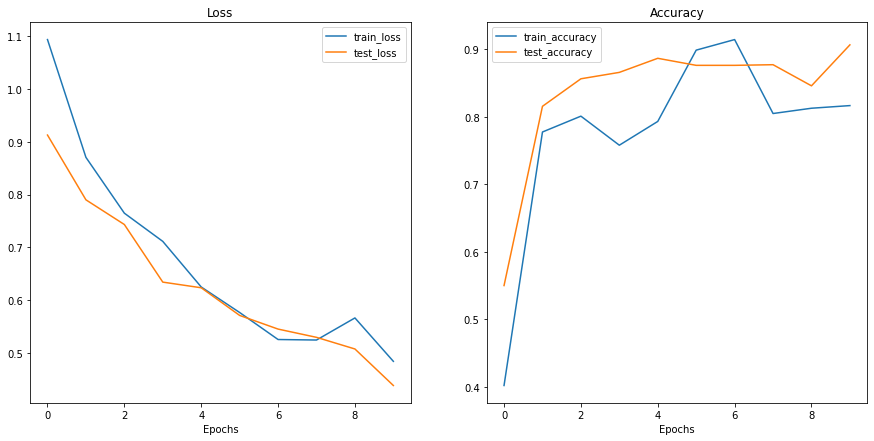

In [17]:
try:
  from helper_functions import plot_loss_curves
except:
  with open("helper_functions.py", "wb") as f:
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(response.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

No appearence of underfitting or overfitting from the loss curves when trained for 10 epochs.

In [21]:
from typing import List, Tuple
from PIL import Image

# predict and display the class label for a single image
def pred_and_plot_image(model: nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (244, 244),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  
  # open image from file path using PIL
  img = Image.open(image_path)

  # set the transforms to apply to the data used to train the model
  if transform is not None:
    image_transform = transform
  else:
    image_transform = auto_transforms # auto transforms found using torchvision.models

  # allocate to device
  model.to(device)

  # turn off gradient tracking and other training functionality
  model.eval()
  with torch.inference_mode():
    # apply transforms, add single batch dimension and allocate to device
    transformed_img = image_transform(img).unsqueeze(dim=0).to(device)

    # pass input through model and store logit output
    pred_logit = model(transformed_img)
  # calculate numerical class label
  pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  # index the set of class names to get the predicted string label 
  pred_class = class_names[pred_label]

  plt.figure(figsize=(5,5))
  plt.imshow(img)
  plt.title(f"Predicted Class: {pred_class}")
  plt.axis(False)


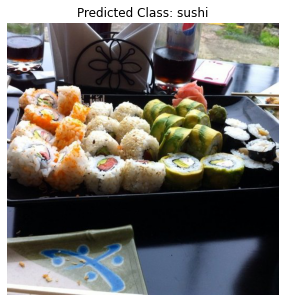

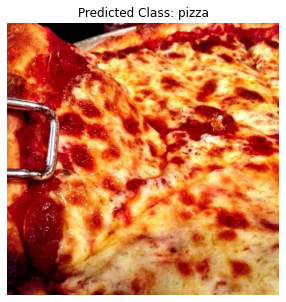

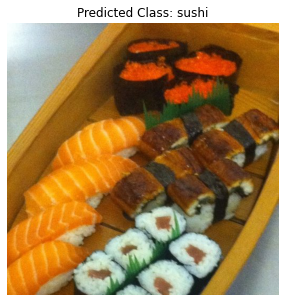

In [22]:
import random
# return a list of all jpeg image paths within test folder
test_image_paths = list(Path(test_folder).glob("*/*.jpg"))
# select 3 random image paths from list
test_image_sample = random.sample(test_image_paths, k=3)

for img_path in test_image_sample:
  pred_and_plot_image(model, class_names, img_path)

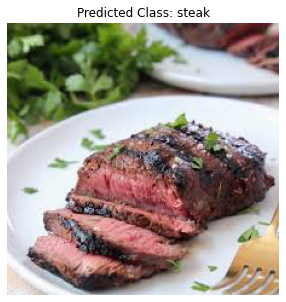

In [23]:
# predict on custom image
custom_image_path = data_path / "steak.jpeg"
pred_and_plot_image(model, class_names, custom_image_path)